In [315]:
import pystan
import pandas as pd
import numpy as np

In [316]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

## Data Set
### IQ measurments
##### We will work with a data set of IQ measurments in different countries, taken from http://viewoniq.org/

In [322]:
iq_data = pd.read_excel('N-IQ-DATA (V1.3.1).xlsx', sheet_name='REC', skiprows=1)

#### We will take only countries with at least 10 samples

In [368]:
interesting_countries = iq_data.groupby('Country name').nunique()[iq_data.groupby('Country name').nunique().ID >= 10][['No.']]

In [369]:
interesting_countries

No.
Country name      
Brazil          21
Canada          10
Germany         10
India           16
Indonesia       18
Jamaica         16
Netherlands     11
Puerto Rico     22
Serbia          12
South Africa    15
Sudan           19
Thailand        17
United States   57

#### We'll take the same number of samples for each country (i.e. 10)

In [350]:
iq_sample = iq_data_sel.groupby('Country name')['IQ (cor.)'].apply(lambda x: np.random.choice(list(x), size=10, replace=False))

In [356]:
iq_samples = pd.DataFrame.from_records(iq_sample, index=iq_sample.index)

In [459]:
iq_samples

0           1           2           3           4  \
Country name                                                                
Brazil          85.043172   83.139165   94.006667   92.161027   95.406521   
Canada          75.329167  102.000000   91.216453   76.024950   94.740000   
Germany         99.280000  107.094005  104.641950  102.895000  105.993836   
India           86.513112   80.374220   82.541794   65.436669   65.094776   
Indonesia       62.992290   83.405400   69.333876   86.200200   83.558213   
Jamaica         74.946048   82.272431   79.014526   82.742691   76.226900   
Netherlands     96.281954   93.730000  101.013355   99.620000  105.040000   
Puerto Rico     74.420000   76.048270   96.707100   81.580000   80.172900   
Serbia          77.510951  100.022652   89.509882   82.608762   95.761357   
South Africa    90.314437   82.125467   64.634791   58.125391   65.699262   
Sudan           74.825536   72.286396   80.856127   65.895893   79.993274   
Thailand       109.743180   81.946299   71.620000   83.980000  104.844683   
United States  109.860000  109.360000   70.500000   88.580000   79.900000   

                        5           6           7           8           9  
Country name                                                               
Brazil          84.328576   91.406900   94.771375   77.764509   84.462914  
Canada         103.600000  101.120000  102.800000   96.202200   68.464857  
Germany        101.085232   87.617876  102.880000   99.520000  105.044776  
India           68.077732   78.395123   82.163333   72.234112   72.029334  
Indonesia       91.347076   81.051200   60.000605   86.200200   81.051200  
Jamaica         54.990000   80.625483   57.280000   79.920000   67.060000  
Netherlands    101.883132  104.959854   94.740000   99.300000  111.630000  
Puerto Rico     84.381439   74.880000   80.870000   92.900000   88.080731  
Serbia          91.183561   99.964874   83.462610   76.320000  107.227721  
South Africa    59.452035   86.350224   89.623936   71.998533   63.500000  
Sudan           67.542172   71.097904   75.530000   75.410258   84.265812  
Thailand        89.017558   77.571544   84.820000   84.482771   52.837782  
United States  101.150000   80.520000  109.940000  100.910975   91.954083

### Define the model
#### A Stan model is organized into sections:

In [ ]:
### Structure of a model, all blocks are optional!!!
"""  
functions {
      // contains user-defined functions
} 

data {
      // declares required data for the model
}

transformed data {
       // allows definition of constants and transforms of the data
}
    
parameters {
       // declares the model’s parameters — the unconstrained version of the parameters is what’s sampled
}
    
transformed parameters {
       // allows variables to be defined in terms of data and parameters that may be used later and will be saved
} 

model {
       // log probability (likelihood?) function is defined
}
    
generated quantities {
       // allows derived quantities based on parameters, data, and optionally (pseudo) random number generation
}
"""

### Now, let's go through the whole process!

#### Define a model for IQ measurements

##### We are politically correct and assume that the IQ follows the same distribution in all countries!
* **Likelihood function**: I assume, the IQ score for country $i$ is distributed according to a normal distribution with mean $\mu_{i}$ and standard deviation $\sigma$
* **Prior**: I assume, that the $\mu_i$ are all distributed according to $\mathcal{N}(100,50)$ and $\sigma$ is uniformly distributed on the interval $[0,100]$

In [475]:
iq_model = """
data {
    // declares required data for the model
    int N; // number of countries
    int M; // number of trials
    matrix[N,M] iq_scores; // observed scores
    }
parameters {
  // declares the model’s parameters — the unconstrained version of the parameters is what’s sampled
  vector[N] mu;
  vector[N] sigma;
    }
model {
  // Set the priors
  for(i in 1:N){
    mu[i] ~ normal(100,50);
    sigma[i] ~ uniform(0,100);
  }
  // Define the likelihood
  for(i in 1:N){
    iq_scores[i] ~ normal(mu[i],sigma[i]);
  }
}
    

"""

### Compile the model

##### Do this once cause it takes time... Then you can fit it with different data sets! 

In [476]:
iq_tests_sm = pystan.StanModel(model_code=iq_model) #Give the model as a string
#iq_tests_sm = pystan.StanModel('iq_measurements.model') # Give the model as a file

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e6c69ef227d7b0c5f6616b32a74126a6 NOW.
/Users/leahelmers/idalab/pystan-workshop/.venv/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/1d/yd0w7_912db1cn41gmzw0mvh0000gn/T/tmpxjufvkv5/stanfit4anon_model_e6c69ef227d7b0c5f6616b32a74126a6_1783882501980366162.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


### Bring the data into PyStan format

##### Data has to be handed over in the form of a dictionary in PyStan
* In our data block in the model definition, we declared the variables *N, M* and *iq_scores*
* These have to be passed to the model

In [443]:
N=iq_samples.shape[0] # Number of countries (13)
M=iq_samples.shape[1] # Number of samples per country (10)

In [477]:
data = {'N': N,
        'M': M,
        'iq_scores': iq_samples.values}

### Fit the previously compiled model

In [478]:
iq_test_fit_variable_sigma = iq_tests_sm.sampling(data=data)

RuntimeError: Initialization failed.

### Now, we can have a look at the results!
* The fit model shows us the most used and relevant mean and modes for each parameter we wanted to estimate
* It gives us the convergence parameter $\hat{R}$

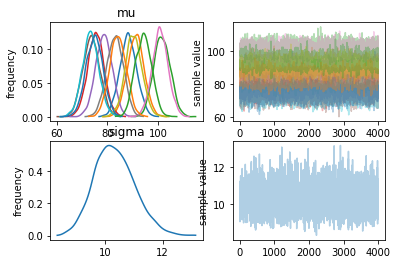

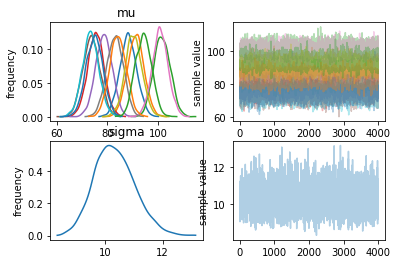

In [466]:
iq_test_fit.traceplot()

In [425]:
iq_test_fit

Inference for Stan model: anon_model_e4f55a3ec7cf42e54e4c4f7c49050434.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[1]   88.25    0.03   3.33  81.75   86.0  88.21  90.46  94.77   9386    1.0
mu[2]   91.18    0.04   3.31  84.55  89.03  91.22  93.37  97.67   8431    1.0
mu[3]   101.6    0.03   3.27  95.41  99.35 101.55 103.81 107.94   8941    1.0
mu[4]   75.42    0.03   3.22  69.03  73.28  75.42  77.55  81.93   9151    1.0
mu[5]   78.58    0.03   3.24  72.21  76.34  78.61  80.79  84.79   8603    1.0
mu[6]   73.66    0.04   3.36  67.25  71.38  73.67  75.85  80.25   8105    1.0
mu[7]  100.87    0.04   3.14  94.58   98.8 100.82 102.94  107.1   7834    1.0
mu[8]   83.03    0.04   3.27  76.63  80.78  83.08  85.28  89.34   7772    1.0
mu[9]   90.37    0.03    3.3  83.79  88.19  90.35   92.5  96.93  10016    1.0
mu[10]  73.35    0.04   3.25  6

#### The fitted model instance contains all the samples drawn and we can thus plot the posterior distribution for each estimated parameter

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13d8e9f98>,
      dtype=object)

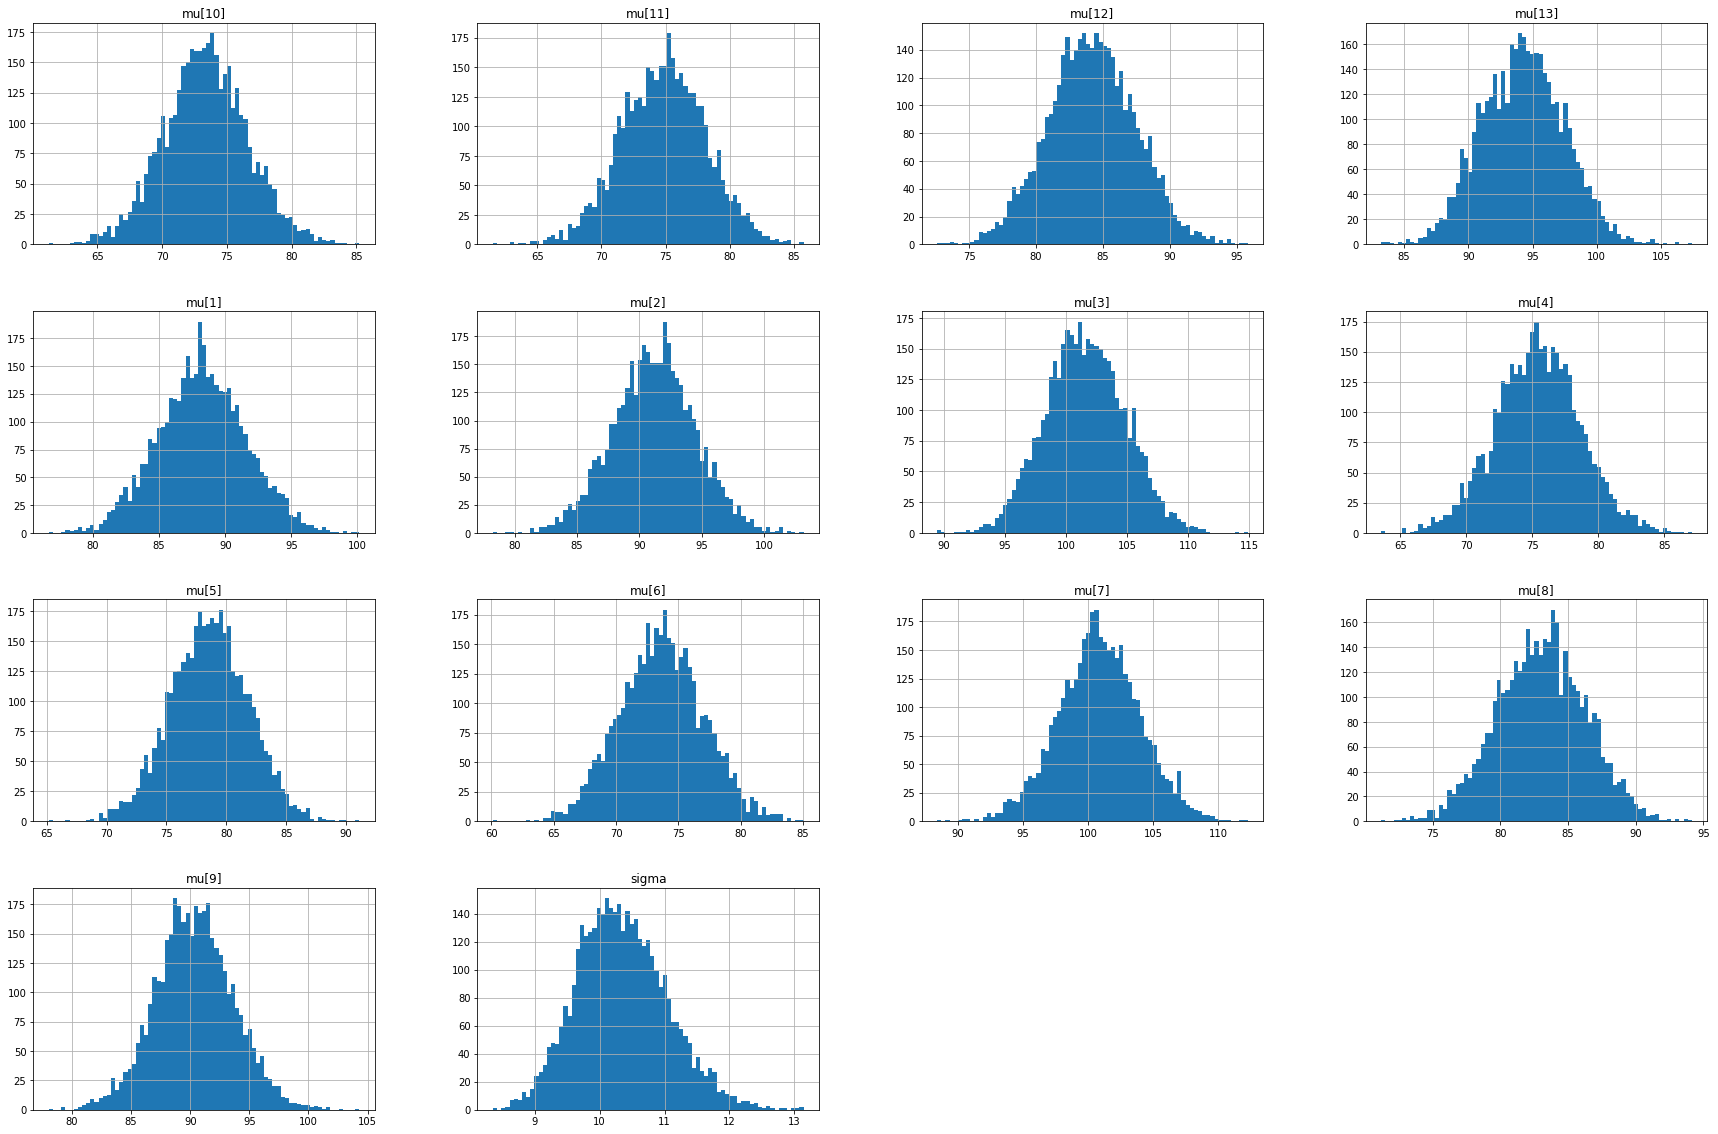

In [463]:
#data_corr
iq_test_fit.to_dataframe()[['mu[1]','mu[2]', 'mu[3]', 'mu[4]', 'mu[5]', 'mu[6]', 'mu[7]',
                            'mu[8]', 'mu[9]', 'mu[10]', 'mu[11]', 'mu[12]', 'mu[13]','sigma']].hist(figsize=(30,20), bins=75)

### Several chains are run for each parameter. To see, how good the sampling converged

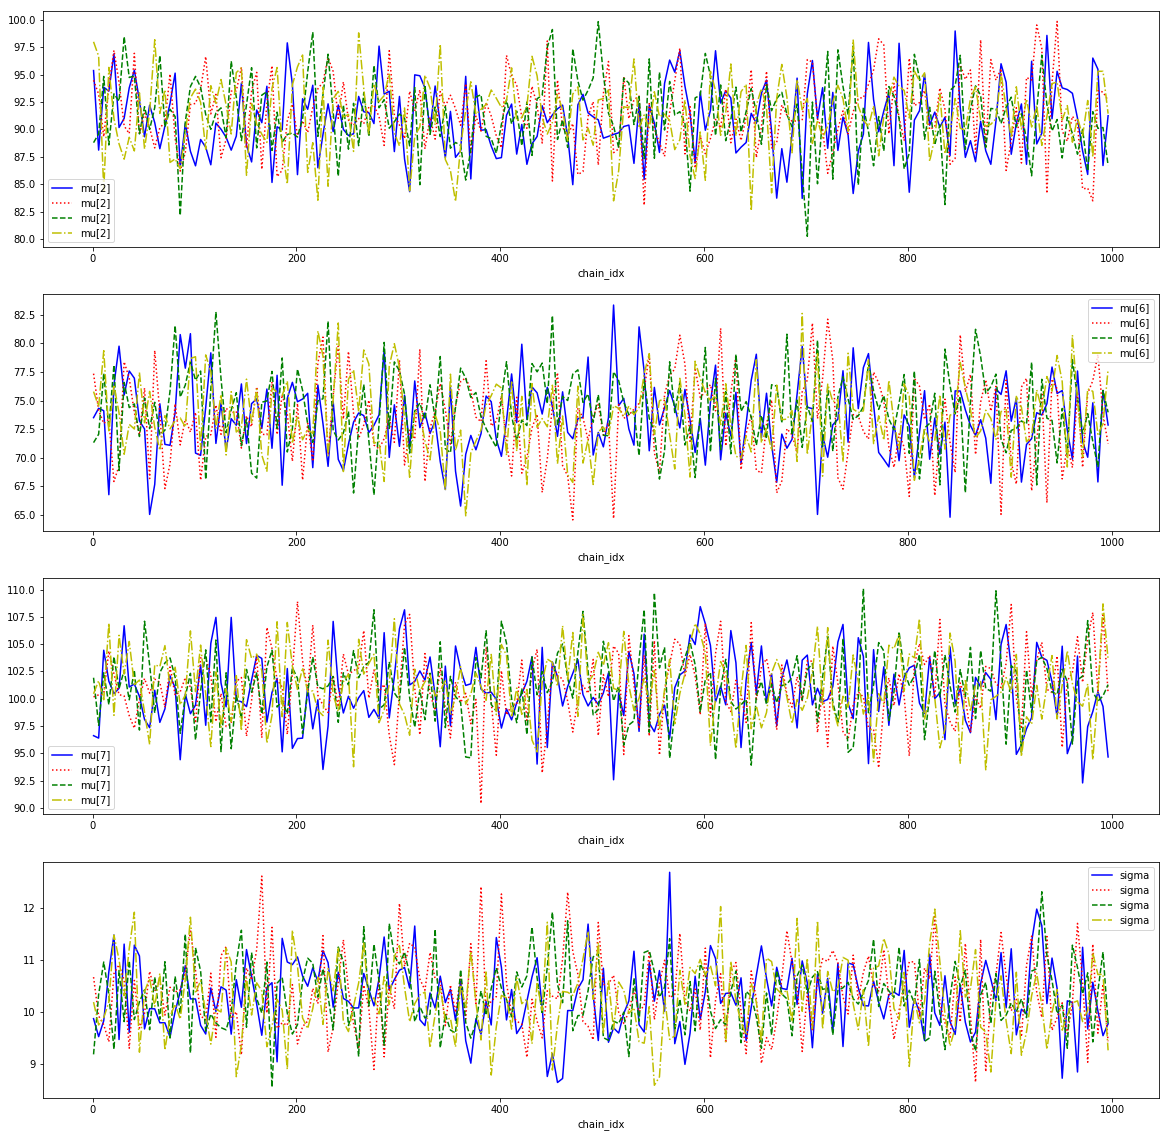

In [422]:
#data_corr
fig, axes = plt.subplots(4,1, figsize=(20,20))
for chain, df in iq_test_fit.to_dataframe().groupby(['chain']):
    df[::5].plot(x='chain_idx', y='mu[2]', ax=axes[0], c=color_dict[chain], linestyle=linestyle_dict[chain])
    df[::5].plot(x='chain_idx', y='mu[6]', ax=axes[1], c=color_dict[chain], linestyle=linestyle_dict[chain])
    df[::5].plot(x='chain_idx', y='mu[7]', ax=axes[2], c=color_dict[chain], linestyle=linestyle_dict[chain])
    df[::5].plot(x='chain_idx', y='sigma', ax=axes[3], c=color_dict[chain], linestyle=linestyle_dict[chain])

### The journey doesn't end here!

* Here we have clearly normally distributed data
* In more complex cases where you don't have a conjugate prior setting, you would now start to estimate the posterior distribution by exploring
    * mean, modes, etc...

### Here you can find further information on Bayesian sampling
* *STAN homepage:* http://mc-stan.org/
* *PyStan homepage:* https://pystan.readthedocs.io/en/latest/
* *Wikipedia list of conjugate priors:* https://en.wikipedia.org/wiki/Conjugate_prior